In [1]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 10.7 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import pandas as pd
import seaborn as sns
import spacy
from collections import Counter
import itertools
import numpy as np
from sklearn.model_selection import train_test_split

nlp = spacy.load('en_core_web_sm')

In [4]:
def get_count_plot(data, feature):
  ax = sns.countplot(data=data, x=feature)
  # add counts to the plot
  ax.bar_label(ax.containers[0])

In [5]:
def describe_and_plot_histogram(data, feature):
  print(data.groupby('label')[feature].describe())
  sns.histplot(data=data, x=feature, hue='label', kde=True)    

# Initial data overview

In [6]:
raw_data_path = 'data/SMSSpamCollection'
data = pd.read_csv(raw_data_path, sep = '\t', header=None, names=['label', 'text'])

In [7]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
data.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
data.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [10]:
# drop duplicates to avoid having the same samples in train/test dataset later on
data.drop_duplicates(inplace=True, ignore_index=True)

In [11]:
# sanity check
data.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4516   4516  Go until jurong point, crazy.. Available only ...    1
spam    653    653  Free entry in 2 a wkly comp to win FA Cup fina...    1

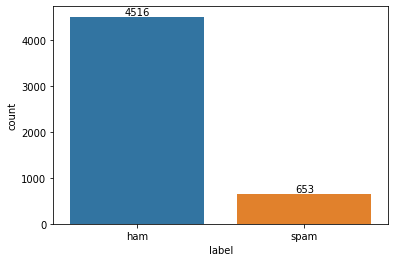

In [12]:
get_count_plot(data, 'label')

# Text features

In [13]:
def get_token_info(text):
  doc = nlp(text)

  token_counter = len(doc)
  alpha_counter = 0
  digit_counter = 0
  punct_counter = 0

  lemmas = []
  pos = []
  is_stop_word = []
  is_punct = []

  for token in doc:
    # counters
    alpha_counter += token.is_alpha
    digit_counter += token.is_digit
    punct_counter += token.is_punct

    # linguistic features
    lemmas.append(token.lemma_)
    pos.append(token.tag_)
    is_stop_word.append(token.is_stop)
    is_punct.append(token.is_punct)

  return {
      'text_length': len(text),
      'number_of_tokens': token_counter,
      # alpha tokens
      'number_of_alpha_tokens': alpha_counter,
      'fract_of_alpha_tokens': alpha_counter/token_counter,
      # digit tokens
      'number_of_digit_tokens': digit_counter,
      'fract_of_digit_tokens': digit_counter/token_counter,
      # alpha-digit
      'number_of_alpha_digit_tokens': alpha_counter + digit_counter,
      'fract_of_alpha_digit_tokens': (alpha_counter + digit_counter)/token_counter,
      # punct
      'number_of_punct_tokens': punct_counter,
      'fract_of_punct_tokens': punct_counter/token_counter,
      'number_of_sentences': len(list(doc.sents)),
      # linguistic features
      'lemmas': np.array(lemmas),
      'pos_tags': np.array(pos),
      'is_stop_word': np.array(is_stop_word),
      'is_punct': np.array(is_punct)
  }

In [15]:
token_info = pd.DataFrame.from_records(data['text'].apply(get_token_info).values)
enriched_data = data.join(token_info)

In [16]:
enriched_data.head()

,label,text,text_length,number_of_tokens,number_of_alpha_tokens,fract_of_alpha_tokens,number_of_digit_tokens,fract_of_digit_tokens,number_of_alpha_digit_tokens,fract_of_alpha_digit_tokens,number_of_punct_tokens,fract_of_punct_tokens,number_of_sentences,lemmas,pos_tags,is_stop_word,is_punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,20,0.833333,0,0.000000,20,0.833333,4,0.166667,3,"[go, until, jurong, point, ,, crazy, .., avail...","[VB, IN, NNP, NN, ,, JJ, ., JJ, RB, IN, JJ, CC...","[True, True, False, False, False, False, False...","[False, False, False, False, True, False, True..."
1,ham,Ok lar... Joking wif u oni...,29,8,6,0.750000,0,0.000000,6,0.750000,2,0.250000,2,"[ok, lar, ..., joke, wif, u, oni, ...]","[UH, JJ, :, VBG, NNS, NNP, NN, :]","[False, False, False, False, False, False, Fal...","[False, False, True, False, False, False, Fals..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,31,21,0.677419,3,0.096774,24,0.774194,1,0.032258,2,"[free, entry, in, 2, a, wkly, comp, to, win, F...","[JJ, NN, IN, CD, DT, JJ, NN, TO, VB, NNP, NNP,...","[False, False, True, False, True, False, False...","[False, False, False, False, False, False, Fal..."
3,ham,U dun say so early hor... U c already then say...,49,13,11,0.846154,0,0.000000,11,0.846154,2,0.153846,2,"[U, dun, say, so, early, hor, ..., U, c, alrea...","[NNP, NNP, VBP, RB, JJ, NN, ., NNP, VBP, RB, R...","[False, False, True, True, False, False, False...","[False, False, False, False, False, False, Tru..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,13,0.866667,0,0.000000,13,0.866667,1,0.066667,1,"[nah, I, do, not, think, he, go, to, usf, ,, h...","[UH, PRP, VBP, RB, VB, PRP, VBZ, IN, VB, ,, PR...","[False, True, True, True, False, True, False, ...","[False, False, False, False, False, False, Fal..."


In [17]:
grouped_by_label = enriched_data.groupby('label')

# Text length

        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4516.0   70.905890  56.715046   2.0   34.0   53.0   91.0  910.0
spam    653.0  137.704441  29.821348  13.0  132.0  148.0  157.0  223.0


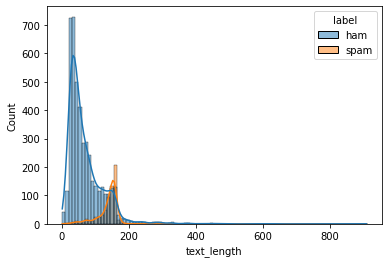

In [18]:
describe_and_plot_histogram(enriched_data, 'text_length')

# Number of tokens

        count       mean        std  min   25%   50%   75%    max
label                                                            
ham    4516.0  17.028344  13.324009  1.0   8.0  13.0  22.0  196.0
spam    653.0  28.607963   7.407056  2.0  26.0  30.0  33.0   49.0


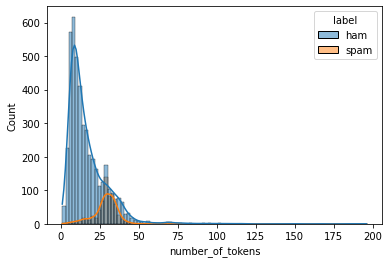

In [19]:
describe_and_plot_histogram(enriched_data, 'number_of_tokens')

# Alpha-digit tokens

        count       mean        std  min   25%   50%   75%    max
label                                                            
ham    4516.0  13.953277  10.857469  0.0   7.0  11.0  18.0  167.0
spam    653.0  21.984686   5.878870  0.0  19.0  23.0  26.0   34.0


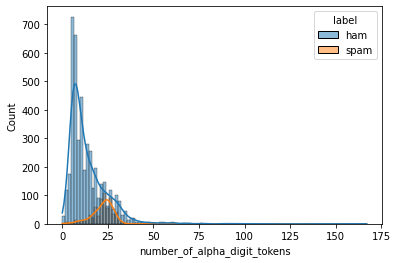

In [20]:
describe_and_plot_histogram(enriched_data, 'number_of_alpha_digit_tokens')

        count      mean       std  min       25%       50%       75%  max
label                                                                    
ham    4516.0  0.817970  0.115438  0.0  0.761905  0.833333  0.888889  1.0
spam    653.0  0.772453  0.111296  0.0  0.709677  0.777778  0.848485  1.0


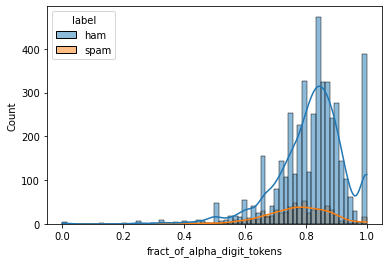

In [21]:
describe_and_plot_histogram(enriched_data, 'fract_of_alpha_digit_tokens')

# Alpha tokens

        count       mean        std  min   25%   50%   75%    max
label                                                            
ham    4516.0  13.784987  10.747049  0.0   7.0  10.0  18.0  167.0
spam    653.0  19.721286   5.676244  0.0  17.0  21.0  24.0   33.0


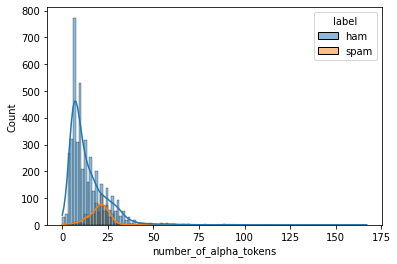

In [22]:
describe_and_plot_histogram(enriched_data, 'number_of_alpha_tokens')

In [23]:
grouped_by_label['fract_of_alpha_tokens'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4516.0,0.808811,0.119329,0.0,0.750000,0.823529,0.878788,1.0
spam,653.0,0.690075,0.121532,0.0,0.612903,0.692308,0.772727,1.0


**Digit tokens**

        count      mean       std  min  25%  50%  75%   max
label                                                      
ham    4516.0  0.168291  0.583665  0.0  0.0  0.0  0.0  10.0
spam    653.0  2.263400  1.481323  0.0  1.0  2.0  3.0   7.0


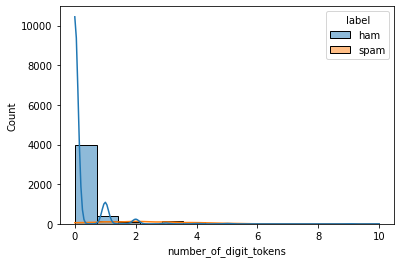

In [24]:
describe_and_plot_histogram(enriched_data, 'number_of_digit_tokens')

This graph is a bit hard to read so let's plot the classes individually

        count      mean       std  min  25%  50%  75%   max
label                                                      
ham    4516.0  0.168291  0.583665  0.0  0.0  0.0  0.0  10.0


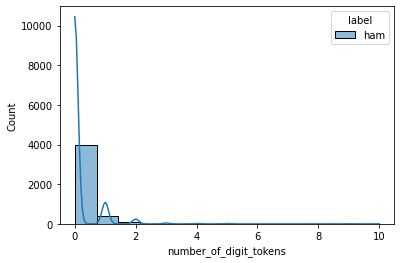

In [25]:
describe_and_plot_histogram(enriched_data[enriched_data['label']=='ham'], 'number_of_digit_tokens')

       count    mean       std  min  25%  50%  75%  max
label                                                  
spam   653.0  2.2634  1.481323  0.0  1.0  2.0  3.0  7.0


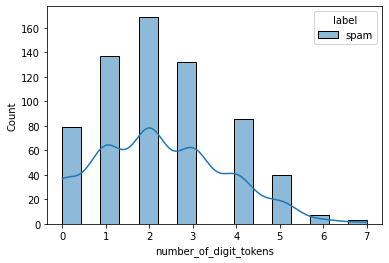

In [26]:
describe_and_plot_histogram(enriched_data[enriched_data['label']=='spam'], 'number_of_digit_tokens')

In [27]:
grouped_by_label['fract_of_digit_tokens'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4516.0,0.009159,0.033132,0.0,0.000000,0.000000,0.000000,1.0
spam,653.0,0.082378,0.060810,0.0,0.037037,0.074074,0.111111,0.5


# Punct tokens

        count      mean       std  min  25%  50%  75%   max
label                                                      
ham    4516.0  2.329052  2.646506  0.0  1.0  2.0  3.0  75.0
spam    653.0  3.931087  2.648040  0.0  2.0  4.0  5.0  21.0


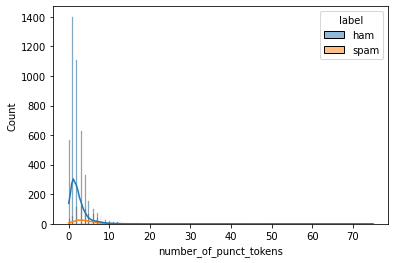

In [28]:
describe_and_plot_histogram(enriched_data, 'number_of_punct_tokens')

        count      mean       std  min  25%  50%  75%   max
label                                                      
ham    4516.0  2.329052  2.646506  0.0  1.0  2.0  3.0  75.0


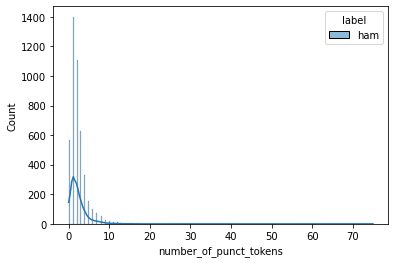

In [29]:
describe_and_plot_histogram(enriched_data[enriched_data['label']=='ham'], 'number_of_punct_tokens')

       count      mean      std  min  25%  50%  75%   max
label                                                    
spam   653.0  3.931087  2.64804  0.0  2.0  4.0  5.0  21.0


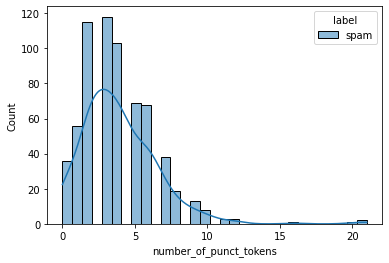

In [30]:
describe_and_plot_histogram(enriched_data[enriched_data['label']=='spam'], 'number_of_punct_tokens')

In [31]:
grouped_by_label['fract_of_punct_tokens'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4516.0,0.138588,0.089912,0.0,0.085016,0.133333,0.187500,1.000000
spam,653.0,0.131745,0.071730,0.0,0.083333,0.129032,0.178571,0.477273


In [32]:
grouped_by_label['number_of_alpha_digit_tokens'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4516.0,13.953277,10.857469,0.0,7.0,11.0,18.0,167.0
spam,653.0,21.984686,5.878870,0.0,19.0,23.0,26.0,34.0


In [33]:
grouped_by_label['fract_of_alpha_digit_tokens'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4516.0,0.817970,0.115438,0.0,0.761905,0.833333,0.888889,1.0
spam,653.0,0.772453,0.111296,0.0,0.709677,0.777778,0.848485,1.0


# Number of sentences

        count      mean       std  min  25%  50%  75%   max
label                                                      
ham    4516.0  1.983835  1.424188  1.0  1.0  2.0  2.0  30.0
spam    653.0  3.202144  1.502205  1.0  2.0  3.0  4.0   8.0


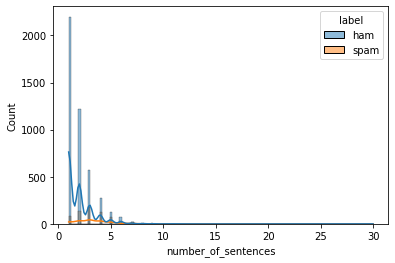

In [34]:
describe_and_plot_histogram(enriched_data, 'number_of_sentences')

# Most common POS tags

In [35]:
spam_counter = Counter(itertools.chain.from_iterable(enriched_data[enriched_data['label']=='spam']['pos_tags']))
ham_counter = Counter(itertools.chain.from_iterable(enriched_data[enriched_data['label']=='ham']['pos_tags']))

In [36]:
def count_feature_and_fract(data, n_most_common, plot=True):
  counter = Counter(data)
  total = sum(counter.values())
  df = pd.DataFrame.from_records(counter.most_common(n_most_common), columns=['feature','count'])
  df['fract'] = df['count'].apply(lambda x: x/total)
  if plot:
    sns.barplot(x=df['feature'], y=df['fract'])
  return df

,feature,count,fract
0,NN,2760,0.147744
1,NNP,2542,0.136074
2,CD,1813,0.097050
3,.,1447,0.077458
4,IN,1266,0.067769
5,VB,1093,0.058509
6,JJ,977,0.052299
7,NNS,738,0.039505
8,DT,737,0.039452
9,RB,548,0.029335


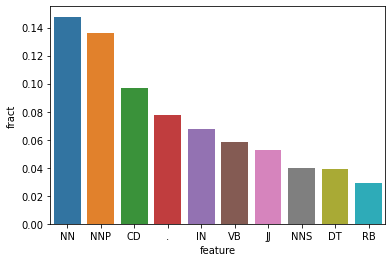

In [37]:
count_feature_and_fract(itertools.chain.from_iterable(enriched_data[enriched_data['label']=='spam']['pos_tags']), 10)

,feature,count,fract
0,NN,9950,0.129389
1,PRP,7267,0.094499
2,.,6395,0.083160
3,NNP,5283,0.068700
4,RB,5058,0.065774
5,IN,4968,0.064603
6,VB,4662,0.060624
7,VBP,3809,0.049532
8,DT,3419,0.044460
9,JJ,3414,0.044395


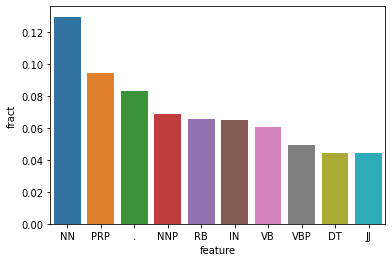

In [38]:
count_feature_and_fract(itertools.chain.from_iterable(enriched_data[enriched_data['label']=='ham']['pos_tags']), 10)

# Most common lemmas

,feature,count,fract
0,.,871,0.046625
1,to,598,0.032011
2,!,426,0.022804
3,be,344,0.018414
4,a,331,0.017719
5,call,314,0.016809
6,",",304,0.016273
7,you,265,0.014186
8,your,244,0.013061
9,£,240,0.012847


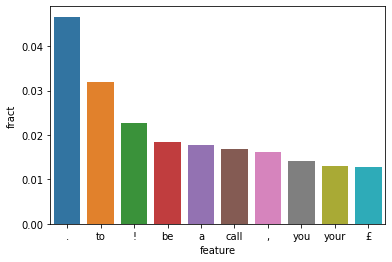

In [39]:
count_feature_and_fract(itertools.chain.from_iterable(enriched_data[enriched_data['label']=='spam']['lemmas']), 10)

,feature,count,fract
0,.,3639,0.047321
1,I,3458,0.044967
2,be,2715,0.035306
3,you,1875,0.024382
4,to,1549,0.020143
5,",",1381,0.017958
6,?,1282,0.016671
7,...,1084,0.014096
8,the,1058,0.013758
9,not,987,0.012835


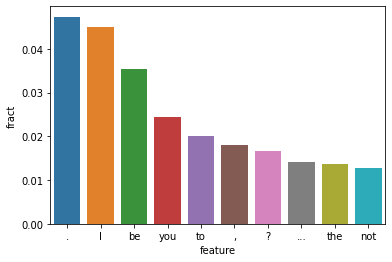

In [40]:
count_feature_and_fract(itertools.chain.from_iterable(enriched_data[enriched_data['label']=='ham']['lemmas']), 10)

Nothing too interesting

# Most common lemmas (no punct)

In [41]:
enriched_data['lemmas_without_punct'] = enriched_data.apply(lambda row: row['lemmas'][~row['is_punct']], axis=1)

,feature,count,fract
0,I,3458,0.052092
1,be,2715,0.040900
2,you,1875,0.028246
3,to,1549,0.023335
4,the,1058,0.015938
5,not,987,0.014868
6,a,971,0.014627
7,do,942,0.014191
8,and,823,0.012398
9,u,771,0.011615


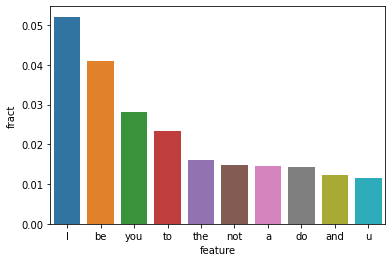

In [42]:
count_feature_and_fract(itertools.chain.from_iterable(enriched_data[enriched_data['label']=='ham']['lemmas_without_punct']), 10)

,feature,count,fract
0,to,598,0.037111
1,be,344,0.021348
2,a,331,0.020541
3,call,314,0.019486
4,you,265,0.016445
5,your,244,0.015142
6,£,240,0.014894
7,for,184,0.011419
8,the,183,0.011357
9,free,165,0.010240


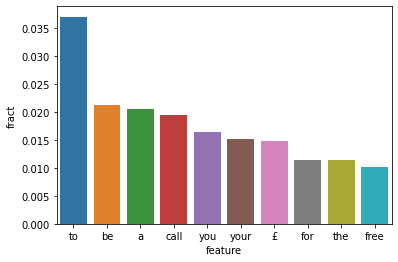

In [43]:
count_feature_and_fract(itertools.chain.from_iterable(enriched_data[enriched_data['label']=='spam']['lemmas_without_punct']), 10)

As expected word **free** is in top 10 most common words in spam category

# Most common lemmas (no punct or stop word)

In [44]:
enriched_data['lemmas_without_puct_and_stop_words'] = enriched_data.apply(lambda row: row['lemmas'][~(row['is_punct'] | row['is_stop_word'])], axis=1)

,feature,count,fract
0,u,771,0.023402
1,,417,0.012657
2,come,299,0.009075
3,2,296,0.008984
4,not,264,0.008013
5,lt;#&gt,254,0.007710
6,go,251,0.007619
7,ok,250,0.007588
8,get,248,0.007527
9,know,244,0.007406


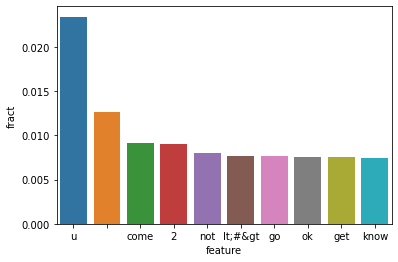

In [45]:
count_feature_and_fract(itertools.chain.from_iterable(enriched_data[enriched_data['label']=='ham']['lemmas_without_puct_and_stop_words']), 10)

,feature,count,fract
0,£,240,0.022284
1,free,165,0.015320
2,2,156,0.014485
3,txt,105,0.009749
4,text,105,0.009749
5,4,99,0.009192
6,claim,97,0.009006
7,ur,97,0.009006
8,win,88,0.008171
9,mobile,88,0.008171


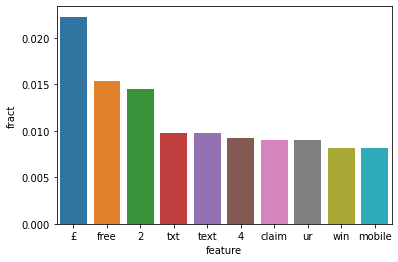

In [46]:
count_feature_and_fract(itertools.chain.from_iterable(enriched_data[enriched_data['label']=='spam']['lemmas_without_puct_and_stop_words']), 10)

Now we see more words that we would expect in spam such as: free, text, win, claim

In [47]:
enriched_data[enriched_data['text'].str.contains('£')]['label'].describe()

count      218
unique       2
top       spam
freq       213
Name: label, dtype: object

In [48]:
with pd.option_context('display.max_colwidth', None):
  print(enriched_data[enriched_data['text'].str.contains('£')]['text'])

5                    FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
8          WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
12           URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
34        Thanks for your subscription to Ringtone UK your mobile will be charged £5/month Please confirm by replying YES or NO. If you reply NO you will not be charged
65              As a valued customer, I am pleased to advise you that following recent review of your Mob No. you are awarded with a £1500 Bonus Prize, call 09066364589
                                                                                      ...                                                                  

As expected, **£** can be almost exclusively found in spam messages, in context of winning a prize or offering a subscription/game

# Notes/Observations
* Class imbalance 4516/653 (ham/spam) -> don't use accuracy for skewed data, use f1 or similar
* Spam messages tend to be longer than ham messages (therefore it's important to not only look at counts of alpha/digit/punct tokens but also fractions)
* Number of punctuation tokens may be somewhat informative feature as spam tends to have number of those, while ham has 1 or 2. (fraction value almost 10x higher for spam)
* The symbol **£** almost exclusive for spam



# Split data

In [49]:
train, val_test = train_test_split(enriched_data, test_size=0.2, random_state=42)

In [50]:
val, test = train_test_split(val_test, test_size=0.5, random_state=1337)

In [51]:
train.to_pickle('data/train.pkl')
val.to_pickle('data/val.pkl')
test.to_pickle('data/test.pkl')